# Load Libraries

In [1]:
#!pip install ..

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import joblib
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

from keras.layers.core import Dense, Dropout, Activation
import keras.callbacks as callbacks
from keras.utils import np_utils


from src.functions.AuxiliarFunctions import *

# Load Data

In [3]:
df_config = pd.read_csv('../data/config.csv')
train_id = 5
df_config

,hash_id,label,wav_files_path,processed_file_folder,processed_file_path,wav_files_info,cv_alg,cv_folds,cv_path,preproc_alg,...,target_id_file,model_path,model_inits,model_neurons,model_status,model_epochs,model_patience,model_learning_rate,model_optimizer,model_batch_size
0,3786470895109500580,Toy Data Classification,../data/shipsEar_AUDIOS,../data,../data/3786470895109500580_processed_data.csv,../data/wav_file_informations.csv,StratifiedKFolds,5,../data/indexes,MFCC,...,../data/models/train_id_file.csv,../data/models,5,../data/models/3786470895109500580_hidden_neur...,../data/models/3786470895109500580_model_statu...,1000,100,0.001,adam,NaN
1,-5662987709573759986,Toy Data Classification,../data/shipsEar_AUDIOS,../data,../data/-5662987709573759986_processed_data.csv,../data/wav_file_informations.csv,StratifiedKFolds,5,../data/indexes,MFCC,...,../data/models/train_id_file.csv,../data/models,5,../data/models/-5662987709573759986_hidden_neu...,../data/models/-5662987709573759986_model_stat...,1000,100,0.001,adam,NaN
2,3837049506038808913,Toy Data Classification,../data/shipsEar_AUDIOS,../data,../data/3837049506038808913_processed_data.csv,../data/wav_file_informations.csv,StratifiedKFolds,5,../data/indexes,MFCC,...,../data/models/train_id_file.csv,../data/models,1,../data/models/3837049506038808913_hidden_neur...,../data/models/3837049506038808913_model_statu...,100,10,0.001,adam,NaN
3,4644399470053765538,Toy Data Classification,../data/shipsEar_AUDIOS,../data,../data/4644399470053765538_processed_data.csv,../data/wav_file_informations.csv,StratifiedKFolds,5,../data/indexes,MFCC,...,../data/models/train_id_file.csv,../data/models,1,../data/models/4644399470053765538_hidden_neur...,../data/models/4644399470053765538_model_statu...,20,10,0.001,adam,NaN
4,5754269668442876343,Toy Data Classification,../data/shipsEar_AUDIOS,../data,../data/5754269668442876343_processed_data.csv,../data/wav_file_informations.csv,StratifiedKFolds,2,../data/indexes,MFCC,...,../data/models/train_id_file.csv,../data/models,2,../data/models/5754269668442876343_hidden_neur...,../data/models/5754269668442876343_model_statu...,10,5,0.001,adam,100.0
5,-8564343657574404315,Toy Data Classification,../data/shipsEar_AUDIOS,../data,../data/-8564343657574404315_processed_data.csv,../data/wav_file_informations.csv,StratifiedKFolds,5,../data/indexes,MFCC,...,../data/models/train_id_file.csv,../data/models,2,../data/models/-8564343657574404315_hidden_neu...,../data/models/-8564343657574404315_model_stat...,100,5,0.001,adam,100.0


In [4]:
df_train = pd.read_csv(df_config['train_data_path'][train_id])

In [5]:
df_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,8.903746,3.184031,0.052501,-9.532997,1.425378,10.894728,0.170885,-0.774334,-10.986876,11.461837,...,10.039516,-7.124313,7.238684,1.278997,11.078094,-10.535044,-0.140006,-8.772590,1.981356,1
1,9.981823,-20.750982,-0.942298,8.656325,0.158986,-10.275792,-0.552505,-0.059739,-11.232473,9.416682,...,-9.691469,18.482490,-11.253873,0.430396,9.836899,10.421699,1.471094,-10.779757,-0.711336,0
2,9.547097,2.984926,0.968209,-10.001620,-0.022503,9.344954,-0.471234,-0.959938,-10.124597,9.963728,...,10.926023,-3.391440,10.230726,1.108343,15.102184,-8.711126,-2.805098,-11.888262,0.759911,1
3,8.357513,20.604116,-0.611071,9.573068,2.036371,9.170248,0.270779,-0.285000,9.534010,9.546351,...,6.925222,-14.570370,-12.142899,-1.077644,10.180091,-10.983669,0.476673,12.383629,-1.151954,1
4,11.301140,21.471281,-0.948023,7.494141,-2.700322,10.126694,-0.853863,-1.600656,10.207078,8.708084,...,8.477780,-11.371481,-9.151545,0.073678,12.375645,-9.216089,-1.500698,10.151696,-0.249882,1


## Fit a preprocessing pipeline for each kFold

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

index_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
n_folds =  df_config['cv_folds'][train_id]

data = df_train.drop(columns=['target'])

for ifold in range(n_folds):
    index_file = '%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                       ifold, n_folds)
    with open(os.path.join(index_path,index_file),'rb') as file_handler:
            [trn_idx,val_idx] = pickle.load(file_handler)
    
    # criando o pipeline
    scaler = None
    if df_config['scaler_alg'][train_id] == "StandardScaler":
        scaler = StandardScaler()
    elif df_config['scaler_alg'][train_id] == "MinMaxScaler":
        scaler = MinMaxScaler()
    
    pipe = Pipeline(steps=[("scaler", scaler)])
    pipe.fit(data.loc[trn_idx,:])
    
    pipe_name = '%s_CV_fold_%i_of_%i_cv_pipe.pkl'%(df_config['hash_id'][train_id],
                                                   ifold, n_folds)
    with open(os.path.join(pipe_path,pipe_name),'wb') as file_handler:
        joblib.dump(pipe, file_handler)

# Define Model Class

In [7]:
class MLPModel:
    def __init__(self, n_hidden_neurons=2, verbose=2):
        self.n_hidden_neurons = n_hidden_neurons
        self.model = None
        self.trn_history = None
        self.trained = False
        self.verbose = verbose
    def __str__(self):
        m_str = 'Class MLPModel\n'
        if self.trained:
            m_str += 'Model is fitted, '
        else:
            m_str += 'Model is not fitted, '
        m_str += 'instance created with %i hidden neurons'%(self.n_hidden_neurons) 
        return m_str
    def model_loss(self, loss_alg='cat_crossent'):
        if loss_alg == 'cat_crossent':
            loss = keras.losses.CategoricalCrossentropy(from_logits=True,
                                                        label_smoothing=0.0,
                                                        axis=-1,
                                                        reduction="auto",
                                                        name=loss_alg,)
        elif loss_alg== 'mse':
            loss = keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
        
        return loss
        
    def model_optimizer(self, optimizer='adam', learning_rate = 0.001):
        if optimizer == 'adam':
            opt = keras.optimizers.Adam(learning_rate=learning_rate,
                                        beta_1=0.9,beta_2=0.999,
                                        epsilon=1e-07,amsgrad=False,
                                        name="Adam",)
        return opt
    
    def create_model(self, data, target, random_state=0, learning_rate=0.01):
        #tf.random.set_seed(random_state)

        model = tf.keras.Sequential()
        
        # add a input to isolate the input of NN model
        model.add(tf.keras.Input(shape=(data.shape[1],)))
        # add a non-linear single neuron layer
        hidden_layer = layers.Dense(units=self.n_hidden_neurons,
                                    activation='tanh',
                                    kernel_initializer=initializers.RandomNormal(stddev=0.01),
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    bias_initializer=initializers.Zeros()
                                   )
        model.add(hidden_layer)
        # add a non-linear output layer with max sparse target shape
        output_layer = layers.Dense(units=target.shape[1],
                                    activation='tanh',
                                    kernel_initializer=initializers.RandomNormal(stddev=0.01),
                                    bias_initializer=initializers.Zeros()
                                   )
        model.add(output_layer)
        # creating a optimization function using steepest gradient
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                                  decay_steps=100,
                                                                  decay_rate=0.9)
        
        # model optimizer
        optimizer = self.model_optimizer(optimizer='adam', learning_rate = 0.001)
        # model loss
        loss = self.model_loss(loss_alg='cat_crossent')
       
        cat_acc_metric = keras.metrics.CategoricalAccuracy(name="cat_acc", dtype=None)
        acc_metric = keras.metrics.Accuracy(name="accuracy",dtype=None)
        mse_metric = keras.metrics.MeanSquaredError(name="mse", dtype=None)
        rmse_metric = keras.metrics.RootMeanSquaredError(name="rmse", dtype=None)

        model.compile(loss=loss, 
                      optimizer=optimizer,
                      metrics=[cat_acc_metric,
                               acc_metric,
                               mse_metric,
                               rmse_metric])
        return model
    def fit(self, X, Y,
            trn_id=None, 
            val_id=None, 
            epochs=50,
            batch_size=4,
            patience = 100,
            learning_rate=0.01, random_state=0):
        
        X_copy = X.copy()
        Y_copy = Y.copy()
        
        model = self.create_model(X_copy,Y_copy, random_state=random_state, learning_rate=learning_rate)
        
        # early stopping to avoid overtraining
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=patience,verbose=self.verbose, 
                                                mode='auto')
    
        trn_desc = model.fit(X_copy[trn_id,:], Y_copy[trn_id],
                             epochs=epochs,
                             batch_size=batch_size,
                             callbacks=[earlyStopping], 
                             verbose=self.verbose,
                             validation_data=(X_copy[val_id,:],
                                              Y_copy[val_id]),
                            )
        self.model = model
        self.trn_history = trn_desc
        self.trained = True
    def predict(self, data):
        return self.model.predict(data)
    def save(self, file_path):
        with open(file_path,'wb') as file_handler:
            joblib.dump([self.n_hidden_neurons, self.model,
                        self.trn_history, self.trained], file_handler)
    def load(self, file_path):
        with open(file_path,'rb') as file_handler:
            [self.n_hidden_neurons, self.model, self.trn_history, self.trained]= joblib.load(file_handler)
    def model_with_no_output_layer(self):
        buffer_model = tf.keras.Sequential()    
        # add a input to isolate the input of NN model
        buffer_model.add(tf.keras.Input(shape=(model.model.layers[0].get_weights()[0].shape[0],)))
        # add a non-linear single neuron layer
        hidden_layer = layers.Dense(units=model.model.layers[0].get_weights()[1].shape[0],
                                    activation='tanh')
        buffer_model.add(hidden_layer)    
        output_layer = layers.Dense(units=1,activation='tanh')
    
        for idx, layer in enumerate(buffer_model.layers):
            layer.set_weights(model.model.layers[idx].get_weights())
        return buffer_model
    def predict_one_layer_before_output(self, data):
        buffer_model = self.model_with_no_output_layer()
        return buffer_model.predict(data)

# kFold training

In [8]:
def get_train_description(df_config, train_id):
    str_out = '\n\n\n'
    str_out +=  '=======================================\n'
    str_out +=  '%s Training Process'%(df_config['label'][train_id])
    str_out += '\n'
    str_out +=  '=======================================\n'
    
    str_out += 'Processing %s'%(df_config['train_data_path'][train_id])+'\n'
    str_out += 'Hidden Neurons:'
    hidden_neurons = ' '
    for ihidden_neuron in list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id])):
        hidden_neurons += str(ihidden_neuron)+', '
    str_out += hidden_neurons[:-2]
    str_out += '\n'
    str_out += 'CV Folds: %s\n'%(df_config['cv_folds'][train_id])
    str_out += 'Inits: %s\n'%(df_config['model_inits'][train_id])
    return str_out

In [9]:
# for kFolds CV

from sklearn.metrics import accuracy_score
from src.functions.AuxiliarFunctions import *


print(get_train_description(df_config, train_id))


if True: # remova quando tiver segurança no treinamento
    print('Training Starting')
    # data
    model_type = 'MLPNeuralNetwork'
    data = df_train.drop(columns=['target']).copy(deep=True)
    print('Data shape: (%i, %i)'%(data.shape[0], data.shape[1]))
    
    trgt = df_train['target'].copy(deep=True).values
    print('Trgt shape: %i'%(trgt.shape[0]))
    
    hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))
    
    with open(df_config['model_status'][train_id],'rb') as file_handler:
        [model_status] = pickle.load(file_handler)
    
    
    n_folds = df_config['cv_folds'][train_id]
    for ifold in range(n_folds):
        print('Training %i fold of %i folds'%(ifold+1, n_folds))
        # pipeline
        pipeline_name = '%s_CV_fold_%i_of_%i_cv_pipe.pkl'%(df_config['hash_id'][train_id],
                                                           ifold, n_folds)
        
        pipeline_path = df_config['pipeline_path'][train_id]
        
        with open(os.path.join(pipeline_path,pipeline_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)
        trn_data = pipe.transform(data)
        trn_trgt = tf.keras.utils.to_categorical(trgt, num_classes=len(np.unique(trgt)))
        
        for idx, ineuron in enumerate(hidden_neurons):
            print('Training for %i neuron in'%(ineuron),hidden_neurons)
            
            for iinit in range(df_config['model_inits'][train_id]):
                print('Training for %i init in %i inits'%(iinit+1, df_config['model_inits'][train_id]))
                model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model.pkl'%(df_config['hash_id'][train_id],
                                                                          model_type,ifold, ineuron, iinit)
                model_path = df_config['model_path'][train_id]
                #print(os.path.join(model_path, model_name))
                if os.path.exists(os.path.join(model_path, model_name)):
                    print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
                    model = MLPModel(n_hidden_neurons=ineuron,verbose=2)
                    model.load(os.path.join(model_path, model_name))
                    
                else:
                    print('Modelo não existe\n\n')
                    model = MLPModel(n_hidden_neurons=ineuron,verbose=2)
                    model.fit(trn_data, trn_trgt, trn_id=trn_idx, val_id=val_idx, 
                              epochs=df_config['model_epochs'][train_id], 
                              random_state=iinit, 
                              learning_rate=df_config['model_learning_rate'][train_id],
                              patience=df_config['model_patience'][train_id],
                              batch_size=int(df_config['model_batch_size'][train_id]),
                             )
                    predictions = model.predict(trn_data)
                    df_predict = pd.DataFrame(data=np.concatenate((trgt[:,np.newaxis], 
                                                                   np.argmax(predictions,axis=1)[:,np.newaxis]),
                                                                  axis=1), 
                                              columns=['target', 'predictions'])
                    prediction_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file.csv'%(df_config['hash_id'][train_id],
                                                                                             model_type,ifold, ineuron, iinit)
                    df_predict.to_csv(os.path.join(model_path, prediction_name),index=False)
                    model.save(os.path.join(model_path, model_name))
                    




Toy Data Classification Training Process
Processing ../data/-8564343657574404315_train_data.csv
Hidden Neurons: 1, 10, 100
CV Folds: 5
Inits: 2

Training Starting
Data shape: (100000, 20)
Trgt shape: 100000
Training 1 fold of 5 folds
Training for 1 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 1.1182 - cat_acc: 0.4882 - accuracy: 0.0000e+00 - mse: 0.2464 - rmse: 0.4964 - val_loss: 0.9462 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.3455 - val_rmse: 0.5878 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 2s - loss: 0.9038 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.4442 - rmse: 0.6665 - val_loss: 0.8783 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.5228 - val_rmse: 0.7231 - 2s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.8653 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.5716 - rmse: 0.7560 - val_loss: 0.8569 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.6118 - va

Epoch 34/100
800/800 - 1s - loss: 0.6104 - cat_acc: 0.4945 - accuracy: 0.0057 - mse: 0.7372 - rmse: 0.8586 - val_loss: 0.6108 - val_cat_acc: 0.4951 - val_accuracy: 0.0066 - val_mse: 0.7375 - val_rmse: 0.8588 - 1s/epoch - 1ms/step
Epoch 35/100
800/800 - 1s - loss: 0.6100 - cat_acc: 0.4946 - accuracy: 0.0068 - mse: 0.7377 - rmse: 0.8589 - val_loss: 0.6120 - val_cat_acc: 0.4946 - val_accuracy: 0.0085 - val_mse: 0.7373 - val_rmse: 0.8587 - 1s/epoch - 2ms/step
Epoch 36/100
800/800 - 1s - loss: 0.6098 - cat_acc: 0.4945 - accuracy: 0.0080 - mse: 0.7384 - rmse: 0.8593 - val_loss: 0.6099 - val_cat_acc: 0.4951 - val_accuracy: 0.0082 - val_mse: 0.7393 - val_rmse: 0.8598 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.6095 - cat_acc: 0.4947 - accuracy: 0.0092 - mse: 0.7388 - rmse: 0.8595 - val_loss: 0.6099 - val_cat_acc: 0.4951 - val_accuracy: 0.0101 - val_mse: 0.7393 - val_rmse: 0.8598 - 1s/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.6092 - cat_acc: 0.4946 - accuracy: 0.0106 - 

Epoch 70/100
800/800 - 1s - loss: 0.6055 - cat_acc: 0.4949 - accuracy: 0.0525 - mse: 0.7460 - rmse: 0.8637 - val_loss: 0.6058 - val_cat_acc: 0.4954 - val_accuracy: 0.0529 - val_mse: 0.7464 - val_rmse: 0.8640 - 1s/epoch - 2ms/step
Epoch 71/100
800/800 - 1s - loss: 0.6054 - cat_acc: 0.4949 - accuracy: 0.0532 - mse: 0.7461 - rmse: 0.8638 - val_loss: 0.6057 - val_cat_acc: 0.4951 - val_accuracy: 0.0542 - val_mse: 0.7461 - val_rmse: 0.8638 - 1s/epoch - 2ms/step
Epoch 72/100
800/800 - 2s - loss: 0.6053 - cat_acc: 0.4949 - accuracy: 0.0539 - mse: 0.7462 - rmse: 0.8639 - val_loss: 0.6058 - val_cat_acc: 0.4958 - val_accuracy: 0.0565 - val_mse: 0.7467 - val_rmse: 0.8641 - 2s/epoch - 2ms/step
Epoch 73/100
800/800 - 1s - loss: 0.6053 - cat_acc: 0.4949 - accuracy: 0.0554 - mse: 0.7463 - rmse: 0.8639 - val_loss: 0.6055 - val_cat_acc: 0.4953 - val_accuracy: 0.0518 - val_mse: 0.7476 - val_rmse: 0.8646 - 1s/epoch - 2ms/step
Epoch 74/100
800/800 - 1s - loss: 0.6051 - cat_acc: 0.4948 - accuracy: 0.0562 - 

INFO:tensorflow:Assets written to: ram://ad522184-ef93-4f25-b6a0-b95a61305bd8/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 1.1879 - cat_acc: 0.4917 - accuracy: 0.0000e+00 - mse: 0.2353 - rmse: 0.4850 - val_loss: 1.0498 - val_cat_acc: 0.5515 - val_accuracy: 0.0000e+00 - val_mse: 0.3075 - val_rmse: 0.5545 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 1.0127 - cat_acc: 0.5111 - accuracy: 0.0000e+00 - mse: 0.4020 - rmse: 0.6341 - val_loss: 0.9908 - val_cat_acc: 0.4951 - val_accuracy: 0.0000e+00 - val_mse: 0.4802 - val_rmse: 0.6929 - 1s/epoch - 1ms/step
Epoch 3/100
800/800 - 1s - loss: 0.9790 - cat_acc: 0.4956 - accuracy: 0.0000e+00 - mse: 0.5295 - rmse: 0.7277 - val_loss: 0.9710 - val_cat_acc: 0.4937 - val_accuracy: 0.0000e+00 - val_mse: 0.5688 - val_rmse: 0.7542 - 1s/epoch - 1ms/step
Epoch 4/100
800/800 - 1s - loss: 0.9586 - cat_acc: 0.4886 - accuracy: 0.0000e+00 - mse: 0.5780 - rmse: 0.7602 - val_loss: 0.9423 - val_cat_acc: 0.4819 - val_accuracy: 0.0000e+00 - val_mse: 0.5776 - val_rmse: 0.7600 - 1s/epoch - 1ms/step
E

Epoch 36/100
800/800 - 1s - loss: 0.7441 - cat_acc: 0.4879 - accuracy: 0.0024 - mse: 0.7110 - rmse: 0.8432 - val_loss: 0.7453 - val_cat_acc: 0.4865 - val_accuracy: 0.0023 - val_mse: 0.7118 - val_rmse: 0.8437 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.7436 - cat_acc: 0.4877 - accuracy: 0.0027 - mse: 0.7119 - rmse: 0.8437 - val_loss: 0.7452 - val_cat_acc: 0.4879 - val_accuracy: 0.0032 - val_mse: 0.7109 - val_rmse: 0.8431 - 1s/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.7431 - cat_acc: 0.4880 - accuracy: 0.0030 - mse: 0.7125 - rmse: 0.8441 - val_loss: 0.7444 - val_cat_acc: 0.4863 - val_accuracy: 0.0029 - val_mse: 0.7148 - val_rmse: 0.8455 - 1s/epoch - 1ms/step
Epoch 39/100
800/800 - 1s - loss: 0.7428 - cat_acc: 0.4875 - accuracy: 0.0032 - mse: 0.7134 - rmse: 0.8446 - val_loss: 0.7444 - val_cat_acc: 0.4865 - val_accuracy: 0.0034 - val_mse: 0.7111 - val_rmse: 0.8433 - 1s/epoch - 1ms/step
Epoch 40/100
800/800 - 1s - loss: 0.7426 - cat_acc: 0.4878 - accuracy: 0.0034 - 

Epoch 72/100
800/800 - 1s - loss: 0.7367 - cat_acc: 0.4877 - accuracy: 0.0149 - mse: 0.7260 - rmse: 0.8521 - val_loss: 0.7384 - val_cat_acc: 0.4865 - val_accuracy: 0.0153 - val_mse: 0.7286 - val_rmse: 0.8536 - 1s/epoch - 1ms/step
Epoch 73/100
800/800 - 1s - loss: 0.7365 - cat_acc: 0.4877 - accuracy: 0.0153 - mse: 0.7262 - rmse: 0.8522 - val_loss: 0.7382 - val_cat_acc: 0.4861 - val_accuracy: 0.0160 - val_mse: 0.7260 - val_rmse: 0.8520 - 1s/epoch - 1ms/step
Epoch 74/100
800/800 - 1s - loss: 0.7365 - cat_acc: 0.4877 - accuracy: 0.0154 - mse: 0.7265 - rmse: 0.8523 - val_loss: 0.7377 - val_cat_acc: 0.4871 - val_accuracy: 0.0159 - val_mse: 0.7282 - val_rmse: 0.8533 - 1s/epoch - 1ms/step
Epoch 75/100
800/800 - 1s - loss: 0.7364 - cat_acc: 0.4874 - accuracy: 0.0159 - mse: 0.7265 - rmse: 0.8524 - val_loss: 0.7379 - val_cat_acc: 0.4870 - val_accuracy: 0.0167 - val_mse: 0.7283 - val_rmse: 0.8534 - 1s/epoch - 1ms/step
Epoch 76/100
800/800 - 1s - loss: 0.7363 - cat_acc: 0.4878 - accuracy: 0.0161 - 

INFO:tensorflow:Assets written to: ram://e6da2b6e-c7c3-4686-9c07-60eddd1b1255/assets


Training for 10 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.6683 - cat_acc: 0.9570 - accuracy: 0.0000e+00 - mse: 0.3255 - rmse: 0.5705 - val_loss: 0.4367 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.5074 - val_rmse: 0.7123 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3951 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.6204 - rmse: 0.7877 - val_loss: 0.3749 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.6946 - val_rmse: 0.8335 - 1s/epoch - 1ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3675 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7156 - rmse: 0.8460 - val_loss: 0.3660 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7309 - val_rmse: 0.8549 - 1s/epoch - 1ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3624 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7369 - rmse: 0.8584 - val_loss: 0.3631 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7432 - v

Epoch 36/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0346 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0343 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0369 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0395 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0457 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0676 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0494 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0373 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0408 - 

Epoch 72/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0743 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0655 - val_mse: 0.7582 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 73/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0656 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0626 - val_mse: 0.7582 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 74/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0558 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0519 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 75/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0864 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.1139 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 76/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.1007 - 

INFO:tensorflow:Assets written to: ram://7ed89fae-7d97-4612-a206-b8e6c952d599/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.6843 - cat_acc: 0.9513 - accuracy: 0.0000e+00 - mse: 0.3508 - rmse: 0.5923 - val_loss: 0.4247 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.5462 - val_rmse: 0.7391 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 2s - loss: 0.3872 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.6485 - rmse: 0.8053 - val_loss: 0.3721 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7076 - val_rmse: 0.8412 - 2s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3657 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7246 - rmse: 0.8512 - val_loss: 0.3648 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7372 - val_rmse: 0.8586 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3616 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7418 - rmse: 0.8613 - val_loss: 0.3625 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7470 - val_rmse: 0.8643 - 1s/epoch - 2ms/step
E

Epoch 36/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0291 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0460 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0267 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0253 - val_mse: 0.7578 - val_rmse: 0.8705 - 1s/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0237 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0228 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0215 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0261 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0261 - 

INFO:tensorflow:Assets written to: ram://a4a6a665-09f9-4b84-b28b-1fb159b931fc/assets


Training for 100 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.4553 - cat_acc: 0.9804 - accuracy: 0.0000e+00 - mse: 0.6224 - rmse: 0.7889 - val_loss: 0.3640 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7471 - val_rmse: 0.8643 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3607 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7508 - rmse: 0.8665 - val_loss: 0.3619 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7543 - val_rmse: 0.8685 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3596 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7540 - rmse: 0.8684 - val_loss: 0.3611 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7556 - val_rmse: 0.8693 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3588 - cat_acc: 0.9928 - accuracy: 6.2500e-06 - mse: 0.7549 - rmse: 0.8688 - val_loss: 0.3605 - val_cat_acc: 0.9918 - val_accuracy: 6.2500e-05 - val_mse: 0.7560 - 

800/800 - 1s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0264 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3577 - val_cat_acc: 0.9918 - val_accuracy: 0.0237 - val_mse: 0.7580 - val_rmse: 0.8706 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3558 - cat_acc: 0.9928 - accuracy: 0.0463 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0506 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0452 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0272 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3559 - cat_acc: 0.9928 - accuracy: 0.0863 - mse: 0.7570 - rmse: 0.8700 - val_loss: 0.3578 - val_cat_acc: 0.9918 - val_accuracy: 0.1108 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3558 - cat_acc: 0.9928 - accuracy: 0.0996 - mse: 0.7570 -

INFO:tensorflow:Assets written to: ram://fdcbd179-b8d7-4493-a42b-307e4e29ed27/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.4565 - cat_acc: 0.9765 - accuracy: 0.0000e+00 - mse: 0.6228 - rmse: 0.7892 - val_loss: 0.3638 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7473 - val_rmse: 0.8645 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3606 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7509 - rmse: 0.8665 - val_loss: 0.3618 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7543 - val_rmse: 0.8685 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3595 - cat_acc: 0.9928 - accuracy: 3.1250e-06 - mse: 0.7541 - rmse: 0.8684 - val_loss: 0.3610 - val_cat_acc: 0.9918 - val_accuracy: 1.2500e-05 - val_mse: 0.7557 - val_rmse: 0.8693 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3588 - cat_acc: 0.9928 - accuracy: 1.5625e-05 - mse: 0.7549 - rmse: 0.8688 - val_loss: 0.3604 - val_cat_acc: 0.9918 - val_accuracy: 8.7500e-05 - val_mse: 0.7561 - val_rmse: 0.8696 - 1s/epoch - 2ms/step
E

Epoch 37/100
800/800 - 1s - loss: 0.3559 - cat_acc: 0.9928 - accuracy: 0.0502 - mse: 0.7570 - rmse: 0.8700 - val_loss: 0.3579 - val_cat_acc: 0.9918 - val_accuracy: 0.0688 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0499 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3577 - val_cat_acc: 0.9918 - val_accuracy: 0.0387 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 38: early stopping
3125/3125 [==============================] - 3s 900us/step
INFO:tensorflow:Assets written to: ram://6789e240-e597-45df-a2d3-3280096f2c34/assets


INFO:tensorflow:Assets written to: ram://6789e240-e597-45df-a2d3-3280096f2c34/assets


Training 2 fold of 5 folds
Training for 1 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 1.1178 - cat_acc: 0.4892 - accuracy: 0.0000e+00 - mse: 0.2452 - rmse: 0.4952 - val_loss: 0.9496 - val_cat_acc: 0.4969 - val_accuracy: 0.0000e+00 - val_mse: 0.3417 - val_rmse: 0.5846 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.9055 - cat_acc: 0.4973 - accuracy: 0.0000e+00 - mse: 0.4397 - rmse: 0.6631 - val_loss: 0.8802 - val_cat_acc: 0.4970 - val_accuracy: 0.0000e+00 - val_mse: 0.5189 - val_rmse: 0.7203 - 1s/epoch - 1ms/step
Epoch 3/100
800/800 - 1s - loss: 0.8659 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.5677 - rmse: 0.7535 - val_loss: 0.8581 - val_cat_acc: 0.4971 - val_accuracy: 0.0000e+00 - val_mse: 0.6092 - val_rmse: 0.7805 - 1s/epoch - 1ms/step
Epoch 4/100
800/800 - 1s - loss: 0.8506 - cat_acc: 0.4975 - accuracy: 0.0000e+00 - mse: 0.6356 - rmse: 0.7973 - val_loss: 0.8477 - val_cat_acc: 0.4972 - val_accuracy: 0.0000

Epoch 36/100
800/800 - 1s - loss: 0.6245 - cat_acc: 0.4900 - accuracy: 0.0115 - mse: 0.7349 - rmse: 0.8573 - val_loss: 0.6256 - val_cat_acc: 0.4904 - val_accuracy: 0.0117 - val_mse: 0.7353 - val_rmse: 0.8575 - 1s/epoch - 1ms/step
Epoch 37/100
800/800 - 1s - loss: 0.6240 - cat_acc: 0.4902 - accuracy: 0.0127 - mse: 0.7354 - rmse: 0.8575 - val_loss: 0.6249 - val_cat_acc: 0.4909 - val_accuracy: 0.0135 - val_mse: 0.7354 - val_rmse: 0.8575 - 1s/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.6237 - cat_acc: 0.4901 - accuracy: 0.0141 - mse: 0.7359 - rmse: 0.8579 - val_loss: 0.6248 - val_cat_acc: 0.4908 - val_accuracy: 0.0158 - val_mse: 0.7354 - val_rmse: 0.8576 - 1s/epoch - 1ms/step
Epoch 39/100
800/800 - 1s - loss: 0.6234 - cat_acc: 0.4902 - accuracy: 0.0155 - mse: 0.7363 - rmse: 0.8581 - val_loss: 0.6248 - val_cat_acc: 0.4898 - val_accuracy: 0.0155 - val_mse: 0.7368 - val_rmse: 0.8584 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.6231 - cat_acc: 0.4902 - accuracy: 0.0170 - 

Epoch 72/100
800/800 - 1s - loss: 0.6186 - cat_acc: 0.4907 - accuracy: 0.0519 - mse: 0.7435 - rmse: 0.8622 - val_loss: 0.6197 - val_cat_acc: 0.4917 - val_accuracy: 0.0543 - val_mse: 0.7429 - val_rmse: 0.8619 - 1s/epoch - 1ms/step
Epoch 73/100
800/800 - 1s - loss: 0.6185 - cat_acc: 0.4909 - accuracy: 0.0525 - mse: 0.7436 - rmse: 0.8623 - val_loss: 0.6201 - val_cat_acc: 0.4915 - val_accuracy: 0.0537 - val_mse: 0.7437 - val_rmse: 0.8624 - 1s/epoch - 1ms/step
Epoch 74/100
800/800 - 1s - loss: 0.6185 - cat_acc: 0.4907 - accuracy: 0.0530 - mse: 0.7437 - rmse: 0.8624 - val_loss: 0.6198 - val_cat_acc: 0.4906 - val_accuracy: 0.0512 - val_mse: 0.7439 - val_rmse: 0.8625 - 1s/epoch - 1ms/step
Epoch 75/100
800/800 - 1s - loss: 0.6184 - cat_acc: 0.4907 - accuracy: 0.0535 - mse: 0.7439 - rmse: 0.8625 - val_loss: 0.6197 - val_cat_acc: 0.4913 - val_accuracy: 0.0546 - val_mse: 0.7438 - val_rmse: 0.8624 - 1s/epoch - 1ms/step
Epoch 76/100
800/800 - 1s - loss: 0.6184 - cat_acc: 0.4908 - accuracy: 0.0544 - 

INFO:tensorflow:Assets written to: ram://8b0eda17-2fd9-4bda-8d50-b62a1cd871aa/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 1.1184 - cat_acc: 0.4894 - accuracy: 0.0000e+00 - mse: 0.2452 - rmse: 0.4951 - val_loss: 0.9498 - val_cat_acc: 0.4963 - val_accuracy: 0.0000e+00 - val_mse: 0.3416 - val_rmse: 0.5845 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.9055 - cat_acc: 0.4972 - accuracy: 0.0000e+00 - mse: 0.4397 - rmse: 0.6631 - val_loss: 0.8801 - val_cat_acc: 0.4970 - val_accuracy: 0.0000e+00 - val_mse: 0.5190 - val_rmse: 0.7204 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 2s - loss: 0.8658 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.5679 - rmse: 0.7536 - val_loss: 0.8580 - val_cat_acc: 0.4970 - val_accuracy: 0.0000e+00 - val_mse: 0.6093 - val_rmse: 0.7806 - 2s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.8506 - cat_acc: 0.4975 - accuracy: 0.0000e+00 - mse: 0.6358 - rmse: 0.7974 - val_loss: 0.8477 - val_cat_acc: 0.4972 - val_accuracy: 0.0000e+00 - val_mse: 0.6598 - val_rmse: 0.8123 - 1s/epoch - 2ms/step
E

Epoch 36/100
800/800 - 1s - loss: 0.6244 - cat_acc: 0.4901 - accuracy: 0.0116 - mse: 0.7349 - rmse: 0.8573 - val_loss: 0.6264 - val_cat_acc: 0.4891 - val_accuracy: 0.0120 - val_mse: 0.7349 - val_rmse: 0.8573 - 1s/epoch - 1ms/step
Epoch 37/100
800/800 - 1s - loss: 0.6241 - cat_acc: 0.4901 - accuracy: 0.0128 - mse: 0.7355 - rmse: 0.8576 - val_loss: 0.6257 - val_cat_acc: 0.4897 - val_accuracy: 0.0138 - val_mse: 0.7355 - val_rmse: 0.8576 - 1s/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.6237 - cat_acc: 0.4900 - accuracy: 0.0142 - mse: 0.7360 - rmse: 0.8579 - val_loss: 0.6251 - val_cat_acc: 0.4906 - val_accuracy: 0.0158 - val_mse: 0.7356 - val_rmse: 0.8577 - 1s/epoch - 1ms/step
Epoch 39/100
800/800 - 1s - loss: 0.6234 - cat_acc: 0.4903 - accuracy: 0.0156 - mse: 0.7362 - rmse: 0.8580 - val_loss: 0.6245 - val_cat_acc: 0.4904 - val_accuracy: 0.0162 - val_mse: 0.7364 - val_rmse: 0.8582 - 1s/epoch - 1ms/step
Epoch 40/100
800/800 - 1s - loss: 0.6231 - cat_acc: 0.4901 - accuracy: 0.0172 - 

INFO:tensorflow:Assets written to: ram://81caa298-92e9-4dec-98cf-fcf27d8be857/assets


Training for 10 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.6690 - cat_acc: 0.9647 - accuracy: 0.0000e+00 - mse: 0.3413 - rmse: 0.5843 - val_loss: 0.4185 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.5523 - val_rmse: 0.7432 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3832 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.6562 - rmse: 0.8101 - val_loss: 0.3713 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7066 - val_rmse: 0.8406 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3655 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7219 - rmse: 0.8496 - val_loss: 0.3649 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7342 - val_rmse: 0.8568 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3617 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7391 - rmse: 0.8597 - val_loss: 0.3626 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7447 - v

Epoch 36/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0360 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0320 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0327 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0558 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0487 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0519 - val_mse: 0.7580 - val_rmse: 0.8706 - 1s/epoch - 1ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0390 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0320 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0437 - 

Epoch 72/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0922 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0739 - val_mse: 0.7582 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 73/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0749 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0785 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 74/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0993 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.1294 - val_mse: 0.7580 - val_rmse: 0.8706 - 1s/epoch - 1ms/step
Epoch 75/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.1170 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.1019 - val_mse: 0.7582 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 76/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0850 - 

INFO:tensorflow:Assets written to: ram://76322b03-4265-49e5-a434-2f9936a0e072/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.6549 - cat_acc: 0.9675 - accuracy: 0.0000e+00 - mse: 0.3436 - rmse: 0.5862 - val_loss: 0.4256 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.5384 - val_rmse: 0.7338 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3911 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.6285 - rmse: 0.7928 - val_loss: 0.3754 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.6877 - val_rmse: 0.8293 - 1s/epoch - 1ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3681 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7091 - rmse: 0.8421 - val_loss: 0.3665 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7257 - val_rmse: 0.8519 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3628 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7326 - rmse: 0.8559 - val_loss: 0.3634 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7399 - val_rmse: 0.8602 - 1s/epoch - 2ms/step
E

Epoch 36/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0279 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0238 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0198 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0163 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0256 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0450 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0391 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0385 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0285 - 

Epoch 72/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0991 - mse: 0.7572 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0701 - val_mse: 0.7582 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 73/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0680 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0674 - val_mse: 0.7582 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 74/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0623 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0849 - val_mse: 0.7580 - val_rmse: 0.8706 - 1s/epoch - 2ms/step
Epoch 75/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0970 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0800 - val_mse: 0.7582 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 76/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0790 - 

INFO:tensorflow:Assets written to: ram://bda39e29-8676-4e34-b10e-a6abd683293e/assets


Training for 100 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.4542 - cat_acc: 0.9798 - accuracy: 0.0000e+00 - mse: 0.6230 - rmse: 0.7893 - val_loss: 0.3639 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7472 - val_rmse: 0.8644 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 2s - loss: 0.3607 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7509 - rmse: 0.8666 - val_loss: 0.3619 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7543 - val_rmse: 0.8685 - 2s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3595 - cat_acc: 0.9928 - accuracy: 3.1250e-06 - mse: 0.7541 - rmse: 0.8684 - val_loss: 0.3611 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7558 - val_rmse: 0.8694 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3588 - cat_acc: 0.9928 - accuracy: 2.1875e-05 - mse: 0.7549 - rmse: 0.8688 - val_loss: 0.3604 - val_cat_acc: 0.9918 - val_accuracy: 5.0000e-05 - val_mse: 0.7562 - 

800/800 - 1s - loss: 0.3558 - cat_acc: 0.9928 - accuracy: 0.0501 - mse: 0.7570 - rmse: 0.8700 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0520 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0329 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0345 - val_mse: 0.7579 - val_rmse: 0.8706 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0339 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0283 - val_mse: 0.7580 - val_rmse: 0.8706 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 2s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0282 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3577 - val_cat_acc: 0.9918 - val_accuracy: 0.0688 - val_mse: 0.7581 - val_rmse: 0.8707 - 2s/epoch - 2ms/step
Epoch 39: early stopping
3125/3125 [==============================] - 3s 943us/step
INFO:tens

INFO:tensorflow:Assets written to: ram://26fd280a-a207-4ac1-a145-b979d7e2c001/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 7s - loss: 0.4581 - cat_acc: 0.9751 - accuracy: 0.0000e+00 - mse: 0.6212 - rmse: 0.7882 - val_loss: 0.3639 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7476 - val_rmse: 0.8646 - 7s/epoch - 9ms/step
Epoch 2/100
800/800 - 3s - loss: 0.3607 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7510 - rmse: 0.8666 - val_loss: 0.3619 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7544 - val_rmse: 0.8686 - 3s/epoch - 4ms/step
Epoch 3/100
800/800 - 3s - loss: 0.3595 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7541 - rmse: 0.8684 - val_loss: 0.3611 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7558 - val_rmse: 0.8694 - 3s/epoch - 4ms/step
Epoch 4/100
800/800 - 2s - loss: 0.3588 - cat_acc: 0.9928 - accuracy: 2.1875e-05 - mse: 0.7549 - rmse: 0.8688 - val_loss: 0.3604 - val_cat_acc: 0.9918 - val_accuracy: 5.0000e-05 - val_mse: 0.7563 - val_rmse: 0.8696 - 2s/epoch - 2ms/step
E

INFO:tensorflow:Assets written to: ram://0684adfa-c9f8-4413-b620-a157cb27213b/assets


Training 3 fold of 5 folds
Training for 1 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 1.1189 - cat_acc: 0.4774 - accuracy: 0.0000e+00 - mse: 0.2444 - rmse: 0.4944 - val_loss: 0.9509 - val_cat_acc: 0.4969 - val_accuracy: 0.0000e+00 - val_mse: 0.3400 - val_rmse: 0.5831 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 2s - loss: 0.9064 - cat_acc: 0.4973 - accuracy: 0.0000e+00 - mse: 0.4374 - rmse: 0.6614 - val_loss: 0.8809 - val_cat_acc: 0.4970 - val_accuracy: 0.0000e+00 - val_mse: 0.5163 - val_rmse: 0.7185 - 2s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.8664 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.5658 - rmse: 0.7522 - val_loss: 0.8585 - val_cat_acc: 0.4971 - val_accuracy: 0.0000e+00 - val_mse: 0.6074 - val_rmse: 0.7794 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 2s - loss: 0.8509 - cat_acc: 0.4975 - accuracy: 0.0000e+00 - mse: 0.6343 - rmse: 0.7964 - val_loss: 0.8480 - val_cat_acc: 0.4972 - val_accuracy: 0.0000

Epoch 36/100
800/800 - 1s - loss: 0.6244 - cat_acc: 0.4900 - accuracy: 0.0114 - mse: 0.7348 - rmse: 0.8572 - val_loss: 0.6254 - val_cat_acc: 0.4901 - val_accuracy: 0.0120 - val_mse: 0.7351 - val_rmse: 0.8574 - 1s/epoch - 1ms/step
Epoch 37/100
800/800 - 1s - loss: 0.6240 - cat_acc: 0.4899 - accuracy: 0.0126 - mse: 0.7353 - rmse: 0.8575 - val_loss: 0.6255 - val_cat_acc: 0.4915 - val_accuracy: 0.0144 - val_mse: 0.7349 - val_rmse: 0.8573 - 998ms/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.6237 - cat_acc: 0.4900 - accuracy: 0.0143 - mse: 0.7357 - rmse: 0.8578 - val_loss: 0.6253 - val_cat_acc: 0.4906 - val_accuracy: 0.0161 - val_mse: 0.7353 - val_rmse: 0.8575 - 1s/epoch - 1ms/step
Epoch 39/100
800/800 - 1s - loss: 0.6234 - cat_acc: 0.4902 - accuracy: 0.0156 - mse: 0.7363 - rmse: 0.8581 - val_loss: 0.6249 - val_cat_acc: 0.4897 - val_accuracy: 0.0165 - val_mse: 0.7367 - val_rmse: 0.8583 - 1s/epoch - 1ms/step
Epoch 40/100
800/800 - 1s - loss: 0.6231 - cat_acc: 0.4902 - accuracy: 0.0170

Epoch 72/100
800/800 - 1s - loss: 0.6186 - cat_acc: 0.4907 - accuracy: 0.0515 - mse: 0.7434 - rmse: 0.8622 - val_loss: 0.6201 - val_cat_acc: 0.4900 - val_accuracy: 0.0490 - val_mse: 0.7446 - val_rmse: 0.8629 - 1s/epoch - 1ms/step
Epoch 73/100
800/800 - 1s - loss: 0.6185 - cat_acc: 0.4907 - accuracy: 0.0518 - mse: 0.7435 - rmse: 0.8622 - val_loss: 0.6194 - val_cat_acc: 0.4912 - val_accuracy: 0.0519 - val_mse: 0.7439 - val_rmse: 0.8625 - 1s/epoch - 1ms/step
Epoch 74/100
800/800 - 1s - loss: 0.6185 - cat_acc: 0.4907 - accuracy: 0.0527 - mse: 0.7437 - rmse: 0.8624 - val_loss: 0.6198 - val_cat_acc: 0.4906 - val_accuracy: 0.0565 - val_mse: 0.7437 - val_rmse: 0.8624 - 1s/epoch - 1ms/step
Epoch 75/100
800/800 - 1s - loss: 0.6184 - cat_acc: 0.4908 - accuracy: 0.0534 - mse: 0.7437 - rmse: 0.8624 - val_loss: 0.6209 - val_cat_acc: 0.4924 - val_accuracy: 0.0563 - val_mse: 0.7433 - val_rmse: 0.8622 - 1s/epoch - 1ms/step
Epoch 76/100
800/800 - 1s - loss: 0.6184 - cat_acc: 0.4906 - accuracy: 0.0542 - 

INFO:tensorflow:Assets written to: ram://9e14d615-6dd5-4666-acab-49e3cdd07d5e/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 1.1201 - cat_acc: 0.4979 - accuracy: 0.0000e+00 - mse: 0.2447 - rmse: 0.4946 - val_loss: 0.9505 - val_cat_acc: 0.4969 - val_accuracy: 0.0000e+00 - val_mse: 0.3401 - val_rmse: 0.5832 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.9061 - cat_acc: 0.4973 - accuracy: 0.0000e+00 - mse: 0.4380 - rmse: 0.6618 - val_loss: 0.8806 - val_cat_acc: 0.4970 - val_accuracy: 0.0000e+00 - val_mse: 0.5174 - val_rmse: 0.7193 - 1s/epoch - 1ms/step
Epoch 3/100
800/800 - 1s - loss: 0.8662 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.5665 - rmse: 0.7526 - val_loss: 0.8583 - val_cat_acc: 0.4970 - val_accuracy: 0.0000e+00 - val_mse: 0.6081 - val_rmse: 0.7798 - 1s/epoch - 1ms/step
Epoch 4/100
800/800 - 1s - loss: 0.8508 - cat_acc: 0.4975 - accuracy: 0.0000e+00 - mse: 0.6347 - rmse: 0.7967 - val_loss: 0.8479 - val_cat_acc: 0.4972 - val_accuracy: 0.0000e+00 - val_mse: 0.6592 - val_rmse: 0.8119 - 1s/epoch - 1ms/step
E

Epoch 36/100
800/800 - 1s - loss: 0.6244 - cat_acc: 0.4901 - accuracy: 0.0116 - mse: 0.7347 - rmse: 0.8571 - val_loss: 0.6258 - val_cat_acc: 0.4906 - val_accuracy: 0.0114 - val_mse: 0.7360 - val_rmse: 0.8579 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.6241 - cat_acc: 0.4902 - accuracy: 0.0128 - mse: 0.7355 - rmse: 0.8576 - val_loss: 0.6252 - val_cat_acc: 0.4904 - val_accuracy: 0.0142 - val_mse: 0.7353 - val_rmse: 0.8575 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.6237 - cat_acc: 0.4900 - accuracy: 0.0143 - mse: 0.7360 - rmse: 0.8579 - val_loss: 0.6255 - val_cat_acc: 0.4901 - val_accuracy: 0.0156 - val_mse: 0.7356 - val_rmse: 0.8577 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.6234 - cat_acc: 0.4901 - accuracy: 0.0158 - mse: 0.7364 - rmse: 0.8581 - val_loss: 0.6245 - val_cat_acc: 0.4912 - val_accuracy: 0.0180 - val_mse: 0.7360 - val_rmse: 0.8579 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.6231 - cat_acc: 0.4903 - accuracy: 0.0174 - 

Epoch 72/100
800/800 - 1s - loss: 0.6187 - cat_acc: 0.4904 - accuracy: 0.0516 - mse: 0.7435 - rmse: 0.8623 - val_loss: 0.6203 - val_cat_acc: 0.4898 - val_accuracy: 0.0519 - val_mse: 0.7439 - val_rmse: 0.8625 - 1s/epoch - 2ms/step
Epoch 73/100
800/800 - 1s - loss: 0.6186 - cat_acc: 0.4905 - accuracy: 0.0526 - mse: 0.7437 - rmse: 0.8624 - val_loss: 0.6198 - val_cat_acc: 0.4914 - val_accuracy: 0.0545 - val_mse: 0.7435 - val_rmse: 0.8622 - 1s/epoch - 1ms/step
Epoch 73: early stopping
3125/3125 [==============================] - 3s 916us/step
INFO:tensorflow:Assets written to: ram://7436e0c8-b874-4de1-86b5-55ec623fb178/assets


INFO:tensorflow:Assets written to: ram://7436e0c8-b874-4de1-86b5-55ec623fb178/assets


Training for 10 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.6883 - cat_acc: 0.9589 - accuracy: 0.0000e+00 - mse: 0.3414 - rmse: 0.5843 - val_loss: 0.4341 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.5271 - val_rmse: 0.7260 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3975 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.6187 - rmse: 0.7866 - val_loss: 0.3807 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.6760 - val_rmse: 0.8222 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3689 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7120 - rmse: 0.8438 - val_loss: 0.3657 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7329 - val_rmse: 0.8561 - 1s/epoch - 1ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3621 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7387 - rmse: 0.8595 - val_loss: 0.3629 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7447 - v

Epoch 36/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0168 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0198 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0274 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0295 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0233 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0264 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0203 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0258 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0217 - 

INFO:tensorflow:Assets written to: ram://b02086d2-ff50-40e6-8330-d60ff060be18/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.6741 - cat_acc: 0.9512 - accuracy: 0.0000e+00 - mse: 0.3207 - rmse: 0.5663 - val_loss: 0.4405 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.4984 - val_rmse: 0.7060 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.4000 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.6044 - rmse: 0.7775 - val_loss: 0.3807 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.6730 - val_rmse: 0.8204 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3699 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7071 - rmse: 0.8409 - val_loss: 0.3665 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7295 - val_rmse: 0.8541 - 1s/epoch - 1ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3626 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7367 - rmse: 0.8583 - val_loss: 0.3631 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7434 - val_rmse: 0.8622 - 1s/epoch - 1ms/step
E

Epoch 36/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0276 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0175 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0271 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0638 - val_mse: 0.7578 - val_rmse: 0.8705 - 1s/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0408 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0274 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0343 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0400 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0525 - 

INFO:tensorflow:Assets written to: ram://1f6e1897-a310-400e-9c55-84a9c80251de/assets


Training for 100 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.4532 - cat_acc: 0.9818 - accuracy: 0.0000e+00 - mse: 0.6226 - rmse: 0.7891 - val_loss: 0.3638 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7475 - val_rmse: 0.8646 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3606 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7510 - rmse: 0.8666 - val_loss: 0.3618 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7543 - val_rmse: 0.8685 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 2s - loss: 0.3595 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7541 - rmse: 0.8684 - val_loss: 0.3611 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7557 - val_rmse: 0.8693 - 2s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3588 - cat_acc: 0.9928 - accuracy: 4.6875e-05 - mse: 0.7549 - rmse: 0.8688 - val_loss: 0.3604 - val_cat_acc: 0.9918 - val_accuracy: 8.7500e-05 - val_mse: 0.7562 - 

800/800 - 1s - loss: 0.3558 - cat_acc: 0.9928 - accuracy: 0.0392 - mse: 0.7570 - rmse: 0.8700 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0406 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0383 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3577 - val_cat_acc: 0.9918 - val_accuracy: 0.0374 - val_mse: 0.7580 - val_rmse: 0.8706 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3558 - cat_acc: 0.9928 - accuracy: 0.0386 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3577 - val_cat_acc: 0.9918 - val_accuracy: 0.0537 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0413 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0343 - val_mse: 0.7580 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3559 - cat_acc: 0.9928 - accuracy: 0.0597 - mse: 0.7569 -

INFO:tensorflow:Assets written to: ram://5a12caa4-d070-4aff-8741-8825460f4dbb/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.4570 - cat_acc: 0.9755 - accuracy: 0.0000e+00 - mse: 0.6179 - rmse: 0.7860 - val_loss: 0.3640 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7471 - val_rmse: 0.8644 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3608 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7508 - rmse: 0.8665 - val_loss: 0.3620 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7543 - val_rmse: 0.8685 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3596 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7540 - rmse: 0.8683 - val_loss: 0.3612 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7556 - val_rmse: 0.8693 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3589 - cat_acc: 0.9928 - accuracy: 9.3750e-06 - mse: 0.7548 - rmse: 0.8688 - val_loss: 0.3605 - val_cat_acc: 0.9918 - val_accuracy: 5.0000e-05 - val_mse: 0.7561 - val_rmse: 0.8695 - 1s/epoch - 2ms/step
E

Epoch 37/100
800/800 - 1s - loss: 0.3558 - cat_acc: 0.9928 - accuracy: 0.0455 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0590 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0417 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0269 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3558 - cat_acc: 0.9928 - accuracy: 0.0758 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3578 - val_cat_acc: 0.9918 - val_accuracy: 0.1122 - val_mse: 0.7580 - val_rmse: 0.8706 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3559 - cat_acc: 0.9928 - accuracy: 0.0956 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3577 - val_cat_acc: 0.9918 - val_accuracy: 0.1195 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 41/100
800/800 - 1s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0941 - 

INFO:tensorflow:Assets written to: ram://c2478859-7165-4ffd-93c0-3676888f26d0/assets


Training 4 fold of 5 folds
Training for 1 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 1.1177 - cat_acc: 0.4825 - accuracy: 0.0000e+00 - mse: 0.2460 - rmse: 0.4960 - val_loss: 0.9458 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.3457 - val_rmse: 0.5880 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.9034 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.4453 - rmse: 0.6673 - val_loss: 0.8780 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.5239 - val_rmse: 0.7238 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.8650 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.5726 - rmse: 0.7567 - val_loss: 0.8566 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.6129 - val_rmse: 0.7829 - 1s/epoch - 1ms/step
Epoch 4/100
800/800 - 1s - loss: 0.8503 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.6392 - rmse: 0.7995 - val_loss: 0.8466 - val_cat_acc: 0.4975 - val_accuracy: 0.0000

Epoch 36/100
800/800 - 1s - loss: 0.6097 - cat_acc: 0.4946 - accuracy: 0.0080 - mse: 0.7383 - rmse: 0.8592 - val_loss: 0.6099 - val_cat_acc: 0.4955 - val_accuracy: 0.0091 - val_mse: 0.7388 - val_rmse: 0.8596 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.6094 - cat_acc: 0.4946 - accuracy: 0.0093 - mse: 0.7389 - rmse: 0.8596 - val_loss: 0.6096 - val_cat_acc: 0.4949 - val_accuracy: 0.0103 - val_mse: 0.7393 - val_rmse: 0.8598 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 2s - loss: 0.6091 - cat_acc: 0.4946 - accuracy: 0.0106 - mse: 0.7393 - rmse: 0.8598 - val_loss: 0.6097 - val_cat_acc: 0.4949 - val_accuracy: 0.0118 - val_mse: 0.7394 - val_rmse: 0.8599 - 2s/epoch - 2ms/step
Epoch 39/100
800/800 - 3s - loss: 0.6089 - cat_acc: 0.4946 - accuracy: 0.0119 - mse: 0.7397 - rmse: 0.8601 - val_loss: 0.6090 - val_cat_acc: 0.4952 - val_accuracy: 0.0132 - val_mse: 0.7404 - val_rmse: 0.8605 - 3s/epoch - 3ms/step
Epoch 40/100
800/800 - 2s - loss: 0.6086 - cat_acc: 0.4946 - accuracy: 0.0134 - 

Epoch 72/100
800/800 - 1s - loss: 0.6053 - cat_acc: 0.4949 - accuracy: 0.0540 - mse: 0.7463 - rmse: 0.8639 - val_loss: 0.6058 - val_cat_acc: 0.4951 - val_accuracy: 0.0538 - val_mse: 0.7464 - val_rmse: 0.8640 - 1s/epoch - 2ms/step
Epoch 73/100
800/800 - 1s - loss: 0.6053 - cat_acc: 0.4948 - accuracy: 0.0551 - mse: 0.7464 - rmse: 0.8640 - val_loss: 0.6061 - val_cat_acc: 0.4956 - val_accuracy: 0.0601 - val_mse: 0.7454 - val_rmse: 0.8634 - 1s/epoch - 2ms/step
Epoch 74/100
800/800 - 1s - loss: 0.6053 - cat_acc: 0.4948 - accuracy: 0.0564 - mse: 0.7463 - rmse: 0.8639 - val_loss: 0.6058 - val_cat_acc: 0.4954 - val_accuracy: 0.0555 - val_mse: 0.7466 - val_rmse: 0.8641 - 1s/epoch - 2ms/step
Epoch 75/100
800/800 - 1s - loss: 0.6051 - cat_acc: 0.4950 - accuracy: 0.0571 - mse: 0.7464 - rmse: 0.8639 - val_loss: 0.6054 - val_cat_acc: 0.4955 - val_accuracy: 0.0547 - val_mse: 0.7475 - val_rmse: 0.8646 - 1s/epoch - 2ms/step
Epoch 76/100
800/800 - 3s - loss: 0.6050 - cat_acc: 0.4950 - accuracy: 0.0570 - 

INFO:tensorflow:Assets written to: ram://06b15311-211e-4ae6-9ace-986cd51b920a/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 1.1179 - cat_acc: 0.4899 - accuracy: 0.0000e+00 - mse: 0.2459 - rmse: 0.4959 - val_loss: 0.9463 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.3452 - val_rmse: 0.5875 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 1s - loss: 0.9038 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.4442 - rmse: 0.6665 - val_loss: 0.8783 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.5230 - val_rmse: 0.7232 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.8652 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.5717 - rmse: 0.7561 - val_loss: 0.8568 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.6121 - val_rmse: 0.7824 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.8504 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.6387 - rmse: 0.7992 - val_loss: 0.8467 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.6612 - val_rmse: 0.8131 - 1s/epoch - 2ms/step
E

Epoch 36/100
800/800 - 1s - loss: 0.6097 - cat_acc: 0.4946 - accuracy: 0.0081 - mse: 0.7384 - rmse: 0.8593 - val_loss: 0.6102 - val_cat_acc: 0.4947 - val_accuracy: 0.0082 - val_mse: 0.7397 - val_rmse: 0.8601 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.6095 - cat_acc: 0.4945 - accuracy: 0.0094 - mse: 0.7389 - rmse: 0.8596 - val_loss: 0.6097 - val_cat_acc: 0.4951 - val_accuracy: 0.0098 - val_mse: 0.7402 - val_rmse: 0.8603 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.6092 - cat_acc: 0.4945 - accuracy: 0.0106 - mse: 0.7394 - rmse: 0.8599 - val_loss: 0.6094 - val_cat_acc: 0.4953 - val_accuracy: 0.0115 - val_mse: 0.7398 - val_rmse: 0.8601 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.6089 - cat_acc: 0.4946 - accuracy: 0.0120 - mse: 0.7398 - rmse: 0.8601 - val_loss: 0.6093 - val_cat_acc: 0.4949 - val_accuracy: 0.0127 - val_mse: 0.7406 - val_rmse: 0.8606 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.6087 - cat_acc: 0.4947 - accuracy: 0.0135 - 

Epoch 72/100
800/800 - 1s - loss: 0.6053 - cat_acc: 0.4948 - accuracy: 0.0541 - mse: 0.7461 - rmse: 0.8638 - val_loss: 0.6055 - val_cat_acc: 0.4954 - val_accuracy: 0.0533 - val_mse: 0.7473 - val_rmse: 0.8645 - 1s/epoch - 2ms/step
Epoch 73/100
800/800 - 1s - loss: 0.6052 - cat_acc: 0.4949 - accuracy: 0.0544 - mse: 0.7464 - rmse: 0.8639 - val_loss: 0.6058 - val_cat_acc: 0.4953 - val_accuracy: 0.0539 - val_mse: 0.7471 - val_rmse: 0.8644 - 1s/epoch - 2ms/step
Epoch 74/100
800/800 - 1s - loss: 0.6052 - cat_acc: 0.4949 - accuracy: 0.0556 - mse: 0.7464 - rmse: 0.8639 - val_loss: 0.6056 - val_cat_acc: 0.4958 - val_accuracy: 0.0582 - val_mse: 0.7466 - val_rmse: 0.8641 - 1s/epoch - 2ms/step
Epoch 75/100
800/800 - 1s - loss: 0.6051 - cat_acc: 0.4950 - accuracy: 0.0566 - mse: 0.7464 - rmse: 0.8639 - val_loss: 0.6060 - val_cat_acc: 0.4946 - val_accuracy: 0.0543 - val_mse: 0.7470 - val_rmse: 0.8643 - 1s/epoch - 2ms/step
Epoch 75: early stopping
3125/3125 [==============================] - 3s 1ms/ste

INFO:tensorflow:Assets written to: ram://87bc6d34-768b-40da-b1c3-f71b37daf504/assets


Training for 10 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 3s - loss: 0.6607 - cat_acc: 0.9388 - accuracy: 0.0000e+00 - mse: 0.3529 - rmse: 0.5941 - val_loss: 0.4165 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.5622 - val_rmse: 0.7498 - 3s/epoch - 3ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3834 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.6557 - rmse: 0.8098 - val_loss: 0.3710 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7078 - val_rmse: 0.8413 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3654 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7230 - rmse: 0.8503 - val_loss: 0.3647 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7353 - val_rmse: 0.8575 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3615 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7401 - rmse: 0.8603 - val_loss: 0.3625 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7456 - v

Epoch 36/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0242 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0221 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0216 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0234 - val_mse: 0.7576 - val_rmse: 0.8704 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0222 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0264 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0254 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0216 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0214 - 

INFO:tensorflow:Assets written to: ram://16dbc13d-2cfb-49a9-956c-a0a847ca68b2/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 3s - loss: 0.6431 - cat_acc: 0.9671 - accuracy: 0.0000e+00 - mse: 0.3575 - rmse: 0.5979 - val_loss: 0.4137 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.5621 - val_rmse: 0.7497 - 3s/epoch - 3ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3864 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.6434 - rmse: 0.8022 - val_loss: 0.3743 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.6951 - val_rmse: 0.8337 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3673 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7160 - rmse: 0.8462 - val_loss: 0.3655 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7333 - val_rmse: 0.8563 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3619 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7398 - rmse: 0.8601 - val_loss: 0.3625 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7463 - val_rmse: 0.8639 - 1s/epoch - 2ms/step
E

Epoch 36/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0209 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3577 - val_cat_acc: 0.9918 - val_accuracy: 0.0384 - val_mse: 0.7576 - val_rmse: 0.8704 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0239 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0207 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0325 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0467 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0302 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0233 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 2s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0278 - 

Epoch 72/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.1035 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0844 - val_mse: 0.7582 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 73/100
800/800 - 2s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0747 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0689 - val_mse: 0.7581 - val_rmse: 0.8707 - 2s/epoch - 2ms/step
Epoch 74/100
800/800 - 2s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0584 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3573 - val_cat_acc: 0.9918 - val_accuracy: 0.0530 - val_mse: 0.7581 - val_rmse: 0.8707 - 2s/epoch - 2ms/step
Epoch 75/100
800/800 - 2s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.0787 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0924 - val_mse: 0.7582 - val_rmse: 0.8707 - 2s/epoch - 2ms/step
Epoch 76/100
800/800 - 1s - loss: 0.3554 - cat_acc: 0.9928 - accuracy: 0.1076 - 

INFO:tensorflow:Assets written to: ram://fba8fe25-c811-4776-896a-bd403c29a7e0/assets


Training for 100 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.4545 - cat_acc: 0.9799 - accuracy: 0.0000e+00 - mse: 0.6222 - rmse: 0.7888 - val_loss: 0.3638 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7472 - val_rmse: 0.8644 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 2s - loss: 0.3607 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7510 - rmse: 0.8666 - val_loss: 0.3618 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7543 - val_rmse: 0.8685 - 2s/epoch - 2ms/step
Epoch 3/100
800/800 - 2s - loss: 0.3595 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7541 - rmse: 0.8684 - val_loss: 0.3611 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7557 - val_rmse: 0.8693 - 2s/epoch - 2ms/step
Epoch 4/100
800/800 - 2s - loss: 0.3588 - cat_acc: 0.9928 - accuracy: 2.8125e-05 - mse: 0.7549 - rmse: 0.8689 - val_loss: 0.3604 - val_cat_acc: 0.9918 - val_accuracy: 5.0000e-05 - val_mse: 0.7562 - 

800/800 - 2s - loss: 0.3559 - cat_acc: 0.9928 - accuracy: 0.1075 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3577 - val_cat_acc: 0.9918 - val_accuracy: 0.1187 - val_mse: 0.7581 - val_rmse: 0.8707 - 2s/epoch - 2ms/step
Epoch 37/100
800/800 - 2s - loss: 0.3558 - cat_acc: 0.9928 - accuracy: 0.1083 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3580 - val_cat_acc: 0.9918 - val_accuracy: 0.1275 - val_mse: 0.7579 - val_rmse: 0.8706 - 2s/epoch - 2ms/step
Epoch 38/100
800/800 - 2s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.1038 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0773 - val_mse: 0.7581 - val_rmse: 0.8707 - 2s/epoch - 2ms/step
Epoch 39/100
800/800 - 2s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0689 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3576 - val_cat_acc: 0.9918 - val_accuracy: 0.0625 - val_mse: 0.7581 - val_rmse: 0.8707 - 2s/epoch - 2ms/step
Epoch 40/100
800/800 - 2s - loss: 0.3557 - cat_acc: 0.9928 - accuracy: 0.0640 - mse: 0.7570 -

INFO:tensorflow:Assets written to: ram://4e193a96-ec3a-4f9b-ad7b-9e66e21f298f/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.4579 - cat_acc: 0.9815 - accuracy: 0.0000e+00 - mse: 0.6187 - rmse: 0.7866 - val_loss: 0.3640 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7468 - val_rmse: 0.8642 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 2s - loss: 0.3607 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7509 - rmse: 0.8665 - val_loss: 0.3619 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7543 - val_rmse: 0.8685 - 2s/epoch - 2ms/step
Epoch 3/100
800/800 - 2s - loss: 0.3596 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7541 - rmse: 0.8684 - val_loss: 0.3611 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7557 - val_rmse: 0.8693 - 2s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3589 - cat_acc: 0.9928 - accuracy: 9.3750e-06 - mse: 0.7548 - rmse: 0.8688 - val_loss: 0.3607 - val_cat_acc: 0.9918 - val_accuracy: 1.8750e-04 - val_mse: 0.7557 - val_rmse: 0.8693 - 1s/epoch - 2ms/step
E

3125/3125 [==============================] - 4s 1ms/step
INFO:tensorflow:Assets written to: ram://720e802c-dda0-4503-b280-953fdfec7e89/assets


INFO:tensorflow:Assets written to: ram://720e802c-dda0-4503-b280-953fdfec7e89/assets


Training 5 fold of 5 folds
Training for 1 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 1.1191 - cat_acc: 0.5214 - accuracy: 0.0000e+00 - mse: 0.2445 - rmse: 0.4945 - val_loss: 0.9502 - val_cat_acc: 0.4969 - val_accuracy: 0.0000e+00 - val_mse: 0.3413 - val_rmse: 0.5842 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 1s - loss: 0.9061 - cat_acc: 0.4972 - accuracy: 0.0000e+00 - mse: 0.4382 - rmse: 0.6620 - val_loss: 0.8807 - val_cat_acc: 0.4970 - val_accuracy: 0.0000e+00 - val_mse: 0.5173 - val_rmse: 0.7192 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.8663 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.5662 - rmse: 0.7525 - val_loss: 0.8584 - val_cat_acc: 0.4971 - val_accuracy: 0.0000e+00 - val_mse: 0.6079 - val_rmse: 0.7797 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.8509 - cat_acc: 0.4975 - accuracy: 0.0000e+00 - mse: 0.6347 - rmse: 0.7967 - val_loss: 0.8480 - val_cat_acc: 0.4972 - val_accuracy: 0.0000

Epoch 36/100
800/800 - 1s - loss: 0.6245 - cat_acc: 0.4900 - accuracy: 0.0114 - mse: 0.7348 - rmse: 0.8572 - val_loss: 0.6278 - val_cat_acc: 0.4897 - val_accuracy: 0.0145 - val_mse: 0.7332 - val_rmse: 0.8563 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.6242 - cat_acc: 0.4902 - accuracy: 0.0128 - mse: 0.7354 - rmse: 0.8575 - val_loss: 0.6254 - val_cat_acc: 0.4905 - val_accuracy: 0.0136 - val_mse: 0.7358 - val_rmse: 0.8578 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.6237 - cat_acc: 0.4903 - accuracy: 0.0140 - mse: 0.7358 - rmse: 0.8578 - val_loss: 0.6251 - val_cat_acc: 0.4900 - val_accuracy: 0.0154 - val_mse: 0.7361 - val_rmse: 0.8579 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.6234 - cat_acc: 0.4903 - accuracy: 0.0155 - mse: 0.7364 - rmse: 0.8581 - val_loss: 0.6248 - val_cat_acc: 0.4910 - val_accuracy: 0.0175 - val_mse: 0.7358 - val_rmse: 0.8578 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.6231 - cat_acc: 0.4902 - accuracy: 0.0171 - 

Epoch 72/100
800/800 - 1s - loss: 0.6186 - cat_acc: 0.4908 - accuracy: 0.0513 - mse: 0.7435 - rmse: 0.8622 - val_loss: 0.6200 - val_cat_acc: 0.4909 - val_accuracy: 0.0516 - val_mse: 0.7434 - val_rmse: 0.8622 - 1s/epoch - 2ms/step
Epoch 73/100
800/800 - 1s - loss: 0.6186 - cat_acc: 0.4906 - accuracy: 0.0520 - mse: 0.7436 - rmse: 0.8623 - val_loss: 0.6202 - val_cat_acc: 0.4900 - val_accuracy: 0.0499 - val_mse: 0.7439 - val_rmse: 0.8625 - 1s/epoch - 2ms/step
Epoch 74/100
800/800 - 1s - loss: 0.6185 - cat_acc: 0.4906 - accuracy: 0.0522 - mse: 0.7439 - rmse: 0.8625 - val_loss: 0.6201 - val_cat_acc: 0.4913 - val_accuracy: 0.0531 - val_mse: 0.7439 - val_rmse: 0.8625 - 1s/epoch - 2ms/step
Epoch 75/100
800/800 - 1s - loss: 0.6184 - cat_acc: 0.4907 - accuracy: 0.0527 - mse: 0.7439 - rmse: 0.8625 - val_loss: 0.6195 - val_cat_acc: 0.4916 - val_accuracy: 0.0545 - val_mse: 0.7439 - val_rmse: 0.8625 - 1s/epoch - 2ms/step
Epoch 76/100
800/800 - 1s - loss: 0.6184 - cat_acc: 0.4908 - accuracy: 0.0534 - 

INFO:tensorflow:Assets written to: ram://7c449165-929a-4298-92d7-fbd1ee105295/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 1.1175 - cat_acc: 0.4925 - accuracy: 0.0000e+00 - mse: 0.2461 - rmse: 0.4961 - val_loss: 0.9458 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.3456 - val_rmse: 0.5879 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.9035 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.4449 - rmse: 0.6670 - val_loss: 0.8781 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.5236 - val_rmse: 0.7236 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.8651 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.5724 - rmse: 0.7566 - val_loss: 0.8568 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.6126 - val_rmse: 0.7827 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.8504 - cat_acc: 0.4974 - accuracy: 0.0000e+00 - mse: 0.6392 - rmse: 0.7995 - val_loss: 0.8468 - val_cat_acc: 0.4975 - val_accuracy: 0.0000e+00 - val_mse: 0.6621 - val_rmse: 0.8137 - 1s/epoch - 2ms/step
E

Epoch 36/100
800/800 - 1s - loss: 0.6098 - cat_acc: 0.4944 - accuracy: 0.0079 - mse: 0.7383 - rmse: 0.8592 - val_loss: 0.6101 - val_cat_acc: 0.4954 - val_accuracy: 0.0081 - val_mse: 0.7393 - val_rmse: 0.8598 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.6094 - cat_acc: 0.4946 - accuracy: 0.0089 - mse: 0.7389 - rmse: 0.8596 - val_loss: 0.6096 - val_cat_acc: 0.4950 - val_accuracy: 0.0101 - val_mse: 0.7390 - val_rmse: 0.8596 - 1s/epoch - 2ms/step
Epoch 38/100
800/800 - 1s - loss: 0.6091 - cat_acc: 0.4947 - accuracy: 0.0104 - mse: 0.7392 - rmse: 0.8598 - val_loss: 0.6095 - val_cat_acc: 0.4949 - val_accuracy: 0.0109 - val_mse: 0.7401 - val_rmse: 0.8603 - 1s/epoch - 2ms/step
Epoch 39/100
800/800 - 1s - loss: 0.6089 - cat_acc: 0.4947 - accuracy: 0.0116 - mse: 0.7398 - rmse: 0.8601 - val_loss: 0.6093 - val_cat_acc: 0.4956 - val_accuracy: 0.0137 - val_mse: 0.7397 - val_rmse: 0.8601 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.6087 - cat_acc: 0.4946 - accuracy: 0.0132 - 

Epoch 72/100
800/800 - 1s - loss: 0.6053 - cat_acc: 0.4949 - accuracy: 0.0539 - mse: 0.7462 - rmse: 0.8638 - val_loss: 0.6058 - val_cat_acc: 0.4954 - val_accuracy: 0.0530 - val_mse: 0.7465 - val_rmse: 0.8640 - 1s/epoch - 2ms/step
Epoch 73/100
800/800 - 1s - loss: 0.6053 - cat_acc: 0.4949 - accuracy: 0.0544 - mse: 0.7462 - rmse: 0.8638 - val_loss: 0.6054 - val_cat_acc: 0.4954 - val_accuracy: 0.0547 - val_mse: 0.7465 - val_rmse: 0.8640 - 1s/epoch - 2ms/step
Epoch 74/100
800/800 - 1s - loss: 0.6052 - cat_acc: 0.4950 - accuracy: 0.0556 - mse: 0.7462 - rmse: 0.8639 - val_loss: 0.6054 - val_cat_acc: 0.4956 - val_accuracy: 0.0558 - val_mse: 0.7469 - val_rmse: 0.8642 - 1s/epoch - 2ms/step
Epoch 75/100
800/800 - 1s - loss: 0.6051 - cat_acc: 0.4949 - accuracy: 0.0562 - mse: 0.7465 - rmse: 0.8640 - val_loss: 0.6065 - val_cat_acc: 0.4954 - val_accuracy: 0.0560 - val_mse: 0.7471 - val_rmse: 0.8644 - 1s/epoch - 2ms/step
Epoch 76/100
800/800 - 1s - loss: 0.6051 - cat_acc: 0.4950 - accuracy: 0.0568 - 

INFO:tensorflow:Assets written to: ram://1edc1037-c22c-4785-b3f4-32b3ef38659b/assets


Training for 10 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.6746 - cat_acc: 0.9521 - accuracy: 0.0000e+00 - mse: 0.3194 - rmse: 0.5651 - val_loss: 0.4417 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.4958 - val_rmse: 0.7041 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 1s - loss: 0.4006 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.6036 - rmse: 0.7769 - val_loss: 0.3805 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.6769 - val_rmse: 0.8227 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3698 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7096 - rmse: 0.8424 - val_loss: 0.3666 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7300 - val_rmse: 0.8544 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3627 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7370 - rmse: 0.8585 - val_loss: 0.3632 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7437 - v

Epoch 36/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0260 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0508 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0270 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0270 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0246 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0215 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0241 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0317 - val_mse: 0.7580 - val_rmse: 0.8706 - 1s/epoch - 1ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0404 - 

INFO:tensorflow:Assets written to: ram://5badd70f-052c-4e37-a024-3ab533ba5088/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.6805 - cat_acc: 0.9587 - accuracy: 0.0000e+00 - mse: 0.3110 - rmse: 0.5577 - val_loss: 0.4629 - val_cat_acc: 0.9917 - val_accuracy: 0.0000e+00 - val_mse: 0.4520 - val_rmse: 0.6723 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.4068 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.5912 - rmse: 0.7689 - val_loss: 0.3749 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.6998 - val_rmse: 0.8366 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3665 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7233 - rmse: 0.8505 - val_loss: 0.3649 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7376 - val_rmse: 0.8588 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3616 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7420 - rmse: 0.8614 - val_loss: 0.3625 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7470 - val_rmse: 0.8643 - 1s/epoch - 2ms/step
E

Epoch 36/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0208 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0196 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 37/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0231 - mse: 0.7570 - rmse: 0.8701 - val_loss: 0.3575 - val_cat_acc: 0.9918 - val_accuracy: 0.0625 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 38/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0412 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0290 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 1ms/step
Epoch 39/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0302 - mse: 0.7571 - rmse: 0.8701 - val_loss: 0.3574 - val_cat_acc: 0.9918 - val_accuracy: 0.0472 - val_mse: 0.7581 - val_rmse: 0.8707 - 1s/epoch - 2ms/step
Epoch 40/100
800/800 - 1s - loss: 0.3555 - cat_acc: 0.9928 - accuracy: 0.0324 - 

INFO:tensorflow:Assets written to: ram://45e09f7b-d1e5-46d6-b12c-ab6b674b57a2/assets


Training for 100 neuron in [1, 10, 100]
Training for 1 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.4579 - cat_acc: 0.9775 - accuracy: 0.0000e+00 - mse: 0.6183 - rmse: 0.7863 - val_loss: 0.3640 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7471 - val_rmse: 0.8643 - 2s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3608 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7508 - rmse: 0.8665 - val_loss: 0.3620 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7542 - val_rmse: 0.8685 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3596 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7540 - rmse: 0.8683 - val_loss: 0.3611 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7555 - val_rmse: 0.8692 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3589 - cat_acc: 0.9928 - accuracy: 6.2500e-06 - mse: 0.7548 - rmse: 0.8688 - val_loss: 0.3605 - val_cat_acc: 0.9918 - val_accuracy: 1.2500e-05 - val_mse: 0.7563 - 

3125/3125 [==============================] - 3s 940us/step
INFO:tensorflow:Assets written to: ram://0b51e2ac-a0bf-4506-9daa-4bcb2b9dc15b/assets


INFO:tensorflow:Assets written to: ram://0b51e2ac-a0bf-4506-9daa-4bcb2b9dc15b/assets


Training for 2 init in 2 inits
Modelo não existe


Epoch 1/100
800/800 - 2s - loss: 0.4532 - cat_acc: 0.9782 - accuracy: 0.0000e+00 - mse: 0.6229 - rmse: 0.7892 - val_loss: 0.3638 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7476 - val_rmse: 0.8646 - 2s/epoch - 3ms/step
Epoch 2/100
800/800 - 1s - loss: 0.3606 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7511 - rmse: 0.8667 - val_loss: 0.3618 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7545 - val_rmse: 0.8686 - 1s/epoch - 2ms/step
Epoch 3/100
800/800 - 1s - loss: 0.3595 - cat_acc: 0.9928 - accuracy: 0.0000e+00 - mse: 0.7542 - rmse: 0.8684 - val_loss: 0.3611 - val_cat_acc: 0.9918 - val_accuracy: 0.0000e+00 - val_mse: 0.7558 - val_rmse: 0.8694 - 1s/epoch - 2ms/step
Epoch 4/100
800/800 - 1s - loss: 0.3588 - cat_acc: 0.9928 - accuracy: 9.3750e-06 - mse: 0.7550 - rmse: 0.8689 - val_loss: 0.3604 - val_cat_acc: 0.9918 - val_accuracy: 5.0000e-05 - val_mse: 0.7563 - val_rmse: 0.8696 - 1s/epoch - 2ms/step
E

INFO:tensorflow:Assets written to: ram://39266654-cb8c-47e7-b2db-b3823c0ae250/assets


## Análise de topologia

In [26]:
# for kFolds CV

from sklearn.metrics import accuracy_score
from src.functions.AuxiliarFunctions import *


print(get_train_description(df_config, train_id))


if True: # remova quando tiver segurança no treinamento
    model_type = 'MLPNeuralNetwork'
    
    hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))
    
    n_folds = df_config['cv_folds'][train_id]
    
    figure_of_merit_matrix = np.zeros((len(hidden_neurons),n_folds))
    best_init_matrix = np.zeros((len(hidden_neurons),n_folds))
    
    for ifold in range(n_folds):
        print('Analysing %i fold of %i folds'%(ifold+1, n_folds))
        
        for idx, ineuron in enumerate(hidden_neurons):
            print('Analysing for %i neuron in'%(ineuron),hidden_neurons)
            
            best_figure_of_merit = -9999
            
            for iinit in range(df_config['model_inits'][train_id]):
                print('Analysing for %i init in %i inits'%(iinit+1, df_config['model_inits'][train_id]))
                # repare que mudou!
                model_name = '%s_%s_%i_fold_%i_neuron_%i_init_prediction_file.csv'%(df_config['hash_id'][train_id],
                                                                                    model_type,ifold, ineuron, iinit)
                model_path = df_config['model_path'][train_id]
                #print(os.path.join(model_path, model_name))
                if os.path.exists(os.path.join(model_path, model_name)):
                    print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
                    # adicionar a função de analise acc ou outra
                    df_predictions = pd.read_csv(os.path.join(model_path, model_name))
                    figure_of_merit = accuracy_score(df_predictions['target'].values, df_predictions['predictions'].values)
                    print('Figure of Merit: Acc, value %1.3f'%(figure_of_merit))
                    if best_figure_of_merit < figure_of_merit:
                        figure_of_merit_matrix[idx, ifold] = figure_of_merit
                        best_figure_of_merit = figure_of_merit
                        best_init_matrix[idx,ifold] = iinit
                    
                else:
                    print('Modelo não existe\n\n')
                    # fora!




Toy Data Classification Training Process
Processing ../data/-8564343657574404315_train_data.csv
Hidden Neurons: 1, 10, 100
CV Folds: 5
Inits: 2

Analysing 1 fold of 5 folds
Analysing for 1 neuron in [1, 10, 100]
Analysing for 1 init in 2 inits
Modelo existente em ../data/models/-8564343657574404315_MLPNeuralNetwork_0_fold_1_neuron_0_init_prediction_file.csv
Figure of Merit: Acc, value 0.495
Analysing for 2 init in 2 inits
Modelo existente em ../data/models/-8564343657574404315_MLPNeuralNetwork_0_fold_1_neuron_1_init_prediction_file.csv
Figure of Merit: Acc, value 0.486
Analysing for 10 neuron in [1, 10, 100]
Analysing for 1 init in 2 inits
Modelo existente em ../data/models/-8564343657574404315_MLPNeuralNetwork_0_fold_10_neuron_0_init_prediction_file.csv
Figure of Merit: Acc, value 0.993
Analysing for 2 init in 2 inits
Modelo existente em ../data/models/-8564343657574404315_MLPNeuralNetwork_0_fold_10_neuron_1_init_prediction_file.csv
Figure of Merit: Acc, value 0.993
Analysing for 1

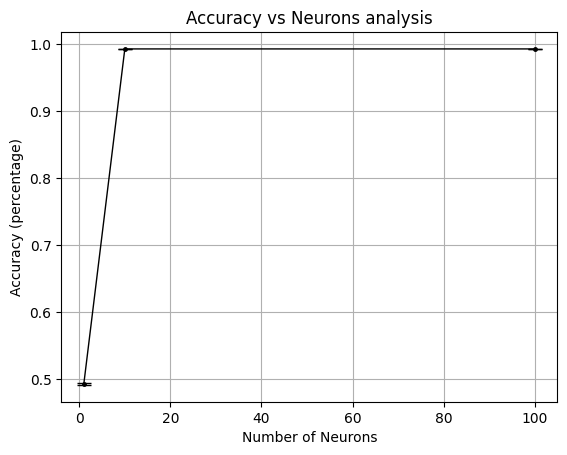

In [23]:
import matplotlib.pyplot as plt

figure_of_merit_label = 'Accuracy'

hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))
mean_figure_of_merit = np.mean(figure_of_merit_matrix[:,:],axis=1)
std_figure_of_merit = np.std(figure_of_merit_matrix[:,:],axis=1) 

linestyle = {"linestyle":"-", "linewidth":1, "markersize":2.5, "markeredgewidth":1, "elinewidth":1, "capsize":5}

plt.errorbar(hidden_neurons, mean_figure_of_merit, yerr=std_figure_of_merit,
             color="k", fmt='o',**linestyle, label='Figure of Merit')
plt.title('%s vs Neurons analysis'%(figure_of_merit_label))
plt.ylabel('%s (percentage)'%(figure_of_merit_label))
plt.xlabel('Number of Neurons')
plt.grid()
plt.show()

## Análise de Relevância

In [70]:
# for kFolds CV

from sklearn.metrics import accuracy_score
from src.functions.AuxiliarFunctions import *


print(get_train_description(df_config, train_id))


if True: # remova quando tiver segurança no treinamento
    print('Analysis Starting')
    # data
    model_type = 'MLPNeuralNetwork'
    data = df_train.drop(columns=['target']).copy(deep=True)
    print('Data shape: (%i, %i)'%(data.shape[0], data.shape[1]))
    
    trgt = df_train['target'].copy(deep=True).values
    print('Trgt shape: %i'%(trgt.shape[0]))
    
    hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))
    
    with open(df_config['model_status'][train_id],'rb') as file_handler:
        [model_status] = pickle.load(file_handler)
    
    
    n_folds = df_config['cv_folds'][train_id]
    model_hidden_neurons = 100 
    
    figure_of_merit_relevance_refence = np.zeros((n_folds,1))
    figure_of_merit_relevance_matrix = np.zeros((n_folds,data.shape[1]))
    
    for ifold in range(n_folds):
        print('Analysing %i fold of %i folds'%(ifold+1, n_folds))
        # pipeline
        pipeline_name = '%s_CV_fold_%i_of_%i_cv_pipe.pkl'%(df_config['hash_id'][train_id],
                                                           ifold, n_folds)
        
        pipeline_path = df_config['pipeline_path'][train_id]
        
        with open(os.path.join(pipeline_path,pipeline_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)
        trn_data = pipe.transform(data)
        trn_trgt = tf.keras.utils.to_categorical(trgt, num_classes=len(np.unique(trgt)))
        
        
        print('Analysing for %i neurons'%(model_hidden_neurons))
            
        model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model.pkl'%(df_config['hash_id'][train_id],
                                                                  model_type, ifold, model_hidden_neurons, 
                                                                  best_init_matrix[hidden_neurons.index(model_hidden_neurons),
                                                                                   ifold])
        model_path = df_config['model_path'][train_id]
            
        if not os.path.exists(os.path.join(model_path, model_name)):    
            print('Modelo não existe\n')
            continue
                
        else:
            print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            model = MLPModel(n_hidden_neurons=ineuron,verbose=2)
            model.load(os.path.join(model_path, model_name))
            predictions = model.predict(trn_data)
            figure_of_merit = accuracy_score(trgt[:,np.newaxis],np.argmax(predictions,axis=1)[:,np.newaxis])
            figure_of_merit_relevance_refence[ifold] = figure_of_merit
            
            for iinput in range(data.shape[1]):
                print('Analysing for %i input in'%(iinput),data.shape[1])
                buffer_data = np.copy(trn_data)
                buffer_data[:,iinput] = np.mean(buffer_data[:,iinput])
                predictions = model.predict(buffer_data)
                figure_of_merit = accuracy_score(trgt[:,np.newaxis],np.argmax(predictions,axis=1)[:,np.newaxis])
                figure_of_merit_relevance_matrix[ifold, iinput] = figure_of_merit




Toy Data Classification Training Process
Processing ../data/-8564343657574404315_train_data.csv
Hidden Neurons: 1, 10, 100
CV Folds: 5
Inits: 2

Analysis Starting
Data shape: (100000, 20)
Trgt shape: 100000
Analysing 1 fold of 5 folds
Analysing for 100 neurons
Modelo existente em ../data/models/-8564343657574404315_MLPNeuralNetwork_0_fold_100_neuron_0_init_model.pkl
3125/3125 [==============================] - 4s 1ms/step
Analysing for 0 input in 20
3125/3125 [==============================] - 4s 1ms/step
Analysing for 1 input in 20
3125/3125 [==============================] - 3s 1ms/step
Analysing for 2 input in 20
3125/3125 [==============================] - 3s 1ms/step
Analysing for 3 input in 20
3125/3125 [==============================] - 3s 1ms/step
Analysing for 4 input in 20
3125/3125 [==============================] - 4s 1ms/step
Analysing for 5 input in 20
3125/3125 [==============================] - 4s 1ms/step
Analysing for 6 input in 20
3125/3125 [======================

3125/3125 [==============================] - 5s 2ms/step
Analysing for 0 input in 20
3125/3125 [==============================] - 5s 2ms/step
Analysing for 1 input in 20
3125/3125 [==============================] - 5s 2ms/step
Analysing for 2 input in 20
3125/3125 [==============================] - 4s 1ms/step
Analysing for 3 input in 20
3125/3125 [==============================] - 4s 1ms/step
Analysing for 4 input in 20
3125/3125 [==============================] - 4s 1ms/step
Analysing for 5 input in 20
3125/3125 [==============================] - 5s 2ms/step
Analysing for 6 input in 20
3125/3125 [==============================] - 5s 1ms/step
Analysing for 7 input in 20
3125/3125 [==============================] - 4s 1ms/step
Analysing for 8 input in 20
3125/3125 [==============================] - 4s 1ms/step
Analysing for 9 input in 20
3125/3125 [==============================] - 4s 1ms/step
Analysing for 10 input in 20
3125/3125 [==============================] - 4s 1ms/step
Analysi

In [51]:
np.mean(figure_of_merit_relevance_matrix,axis=0)

array([0.99174 , 0.992572, 0.99259 , 0.992586, 0.99259 , 0.989704,
       0.99259 , 0.99259 , 0.992572, 0.983722, 0.99259 , 0.99257 ,
       0.958502, 0.992588, 0.99259 , 0.843318, 0.96633 , 0.99259 ,
       0.99259 , 0.99259 ])

In [52]:
np.std(figure_of_merit_relevance_matrix,axis=0)

array([9.45304184e-04, 1.46969385e-05, 1.11022302e-16, 4.89897949e-06,
       1.11022302e-16, 4.27100738e-03, 1.11022302e-16, 1.11022302e-16,
       1.16619038e-05, 6.86884386e-03, 1.11022302e-16, 1.41421356e-05,
       9.68624881e-03, 4.00000000e-06, 1.11022302e-16, 2.15553097e-02,
       1.19823854e-02, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16])

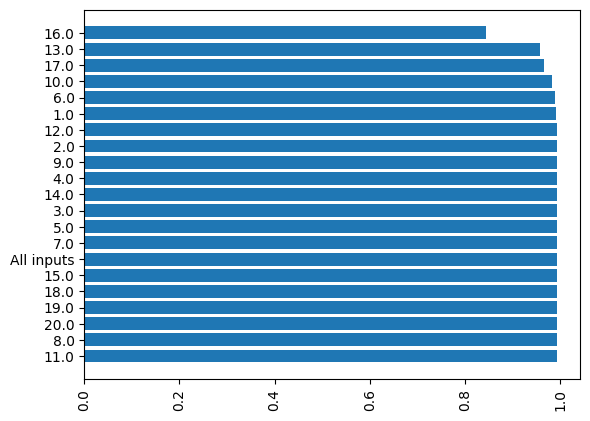

In [158]:
import matplotlib.pyplot as plt


index = np.arange(1,data.shape[1]+1)[:,np.newaxis]
rel_mean = np.mean(figure_of_merit_relevance_matrix,axis=0)[:,np.newaxis]
rel_std = np.std(figure_of_merit_relevance_matrix,axis=0)[:,np.newaxis]

df_relevance = pd.DataFrame(data=np.concatenate((index, rel_mean, rel_std),axis=1), 
                            columns=['input', 'mean', 'std'])
df_relevance = df_relevance.astype({"input": str, "mean": float, "std": float})


index = 'All inputs'
rel_mean = np.mean(figure_of_merit_relevance_refence,axis=0)
rel_std = np.std(figure_of_merit_relevance_refence,axis=0)

df_reference = pd.DataFrame(data=(index, rel_mean[0], rel_std[0])).T
df_reference = df_reference.rename(columns={0:'input', 1:'mean', 2:'std'})

df_relevance = pd.concat([df_relevance, df_reference], axis=0)

df_relevance = df_relevance.sort_values(by=['mean'], ascending=False)


plt.barh(df_relevance['input'], df_relevance['mean'])
plt.xticks(rotation=90)
plt.show()
#df_relevance = np.sort(df_relevance, order=['mean', 'std']) # Sort by mean, then std if means are equal

#plt.barh(np.arange(1,data.shape[1]+1),np.mean(figure_of_merit_relevance_matrix,axis=0))
#plt.show()

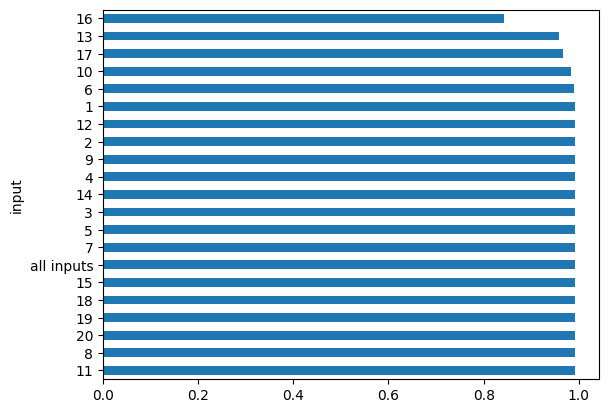

In [136]:
ax = df_relevance.plot.barh(x='input', y='mean', rot=0, legend=False)
plt.show()

In [115]:
df_reference = df_reference.rename(columns={0:'input', 1:'mean', 2:'std'})
df_reference

,input,mean,std
0,all inputs,0.99259,0.0
